# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

# Seed so that I get the same cluster proportions in 3.3
np.random.seed(123)

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter =  ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)

azdias.head(10)

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
pd.set_option('max_rows', None)
print(feat_info.shape)
feat_info

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [6]:
pd.reset_option('max_rows')

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Assess number of missing values in each column
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

The cell above shows how many non-null values exist for each variable. Subtracting from the total points, 891221, gives the  number of natural missing values for each variable. Many variables have the same number of null values, suggesting that they're for the same point (person), but this can be verified.

In [8]:
# Identify missing or unknown data values and convert them to NaNs.

# azdias[azdias.LP_LEBENSPHASE_FEIN.isnull()].shape[0]

feat_info_to_dict = feat_info.drop(['information_level','type'],axis=1)
# feat_info_to_dict.head() # check

# Now convert to dictionary:
feat_info_dict = feat_info_to_dict.set_index('attribute')['missing_or_unknown'].to_dict()
feat_info_dict

{'AGER_TYP': '[-1,0]',
 'ALTERSKATEGORIE_GROB': '[-1,0,9]',
 'ANREDE_KZ': '[-1,0]',
 'CJT_GESAMTTYP': '[0]',
 'FINANZ_MINIMALIST': '[-1]',
 'FINANZ_SPARER': '[-1]',
 'FINANZ_VORSORGER': '[-1]',
 'FINANZ_ANLEGER': '[-1]',
 'FINANZ_UNAUFFAELLIGER': '[-1]',
 'FINANZ_HAUSBAUER': '[-1]',
 'FINANZTYP': '[-1]',
 'GEBURTSJAHR': '[0]',
 'GFK_URLAUBERTYP': '[]',
 'GREEN_AVANTGARDE': '[]',
 'HEALTH_TYP': '[-1,0]',
 'LP_LEBENSPHASE_FEIN': '[0]',
 'LP_LEBENSPHASE_GROB': '[0]',
 'LP_FAMILIE_FEIN': '[0]',
 'LP_FAMILIE_GROB': '[0]',
 'LP_STATUS_FEIN': '[0]',
 'LP_STATUS_GROB': '[0]',
 'NATIONALITAET_KZ': '[-1,0]',
 'PRAEGENDE_JUGENDJAHRE': '[-1,0]',
 'RETOURTYP_BK_S': '[0]',
 'SEMIO_SOZ': '[-1,9]',
 'SEMIO_FAM': '[-1,9]',
 'SEMIO_REL': '[-1,9]',
 'SEMIO_MAT': '[-1,9]',
 'SEMIO_VERT': '[-1,9]',
 'SEMIO_LUST': '[-1,9]',
 'SEMIO_ERL': '[-1,9]',
 'SEMIO_KULT': '[-1,9]',
 'SEMIO_RAT': '[-1,9]',
 'SEMIO_KRIT': '[-1,9]',
 'SEMIO_DOM': '[-1,9]',
 'SEMIO_KAEM': '[-1,9]',
 'SEMIO_PFLICHT': '[-1,9]',
 'SEMIO_TRA

In [9]:
# Convert missing value keys from string of array to array of ints
# For non-numbers X, XX, or empty arrays, take care not to try to change them to ints
for key in feat_info_dict:
    feat_info_dict[key] = feat_info_dict[key].strip('][').split(',')
    feat_info_dict[key] = [int(missing) if (missing!='X' and missing!='XX' and missing!='') 
                                         else missing for missing in feat_info_dict[key]]
        
feat_info_dict

{'AGER_TYP': [-1, 0],
 'ALTERSKATEGORIE_GROB': [-1, 0, 9],
 'ANREDE_KZ': [-1, 0],
 'CJT_GESAMTTYP': [0],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_VORSORGER': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZTYP': [-1],
 'GEBURTSJAHR': [0],
 'GFK_URLAUBERTYP': [''],
 'GREEN_AVANTGARDE': [''],
 'HEALTH_TYP': [-1, 0],
 'LP_LEBENSPHASE_FEIN': [0],
 'LP_LEBENSPHASE_GROB': [0],
 'LP_FAMILIE_FEIN': [0],
 'LP_FAMILIE_GROB': [0],
 'LP_STATUS_FEIN': [0],
 'LP_STATUS_GROB': [0],
 'NATIONALITAET_KZ': [-1, 0],
 'PRAEGENDE_JUGENDJAHRE': [-1, 0],
 'RETOURTYP_BK_S': [0],
 'SEMIO_SOZ': [-1, 9],
 'SEMIO_FAM': [-1, 9],
 'SEMIO_REL': [-1, 9],
 'SEMIO_MAT': [-1, 9],
 'SEMIO_VERT': [-1, 9],
 'SEMIO_LUST': [-1, 9],
 'SEMIO_ERL': [-1, 9],
 'SEMIO_KULT': [-1, 9],
 'SEMIO_RAT': [-1, 9],
 'SEMIO_KRIT': [-1, 9],
 'SEMIO_DOM': [-1, 9],
 'SEMIO_KAEM': [-1, 9],
 'SEMIO_PFLICHT': [-1, 9],
 'SEMIO_TRADV': [-1, 9],
 'SHOPPER_TYP': [-1],
 'SOHO_KZ': [-

In [10]:
# Make copy of original dataframe for cleaning
azdias_clean = azdias.copy()

# Replace missing or unknown values with NaN
for key in feat_info_dict:
    azdias_clean[key].replace(to_replace=feat_info_dict[key],value=np.nan,inplace=True)

In [11]:
# Test
azdias_clean.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [12]:
# Test
azdias_clean[azdias.CAMEO_INTL_2015=='XX']

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
2511,NaN,2.0,2,6.0,4,2,4,3,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,5.0
4569,NaN,3.0,2,2.0,4,2,3,4,1,1,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,5.0,5.0,4.0
9803,2.0,4.0,2,2.0,5,1,5,1,1,3,...,2.0,3.0,3.0,0.0,3.0,3.0,3.0,4.0,8.0,3.0
16700,3.0,3.0,2,1.0,5,1,5,1,3,3,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,5.0,2.0
16883,2.0,4.0,2,2.0,5,1,5,1,2,3,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,3.0,5.0,3.0
22386,NaN,2.0,1,1.0,5,3,2,2,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,4.0,8.0,3.0
28123,2.0,1.0,2,5.0,4,1,5,1,3,2,...,2.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,4.0,1.0
31618,NaN,3.0,2,3.0,4,4,1,4,5,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,6.0,3.0
32864,NaN,4.0,2,4.0,5,1,5,1,2,4,...,2.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,7.0,5.0
33666,3.0,3.0,1,4.0,5,1,4,1,1,2,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,4.0,8.0,3.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the dataset

azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

In [14]:
nan_dict = {}
# Make a dictionary with column names as the key and percentage of missing values as the value:
for key in feat_info_dict:
    nan_dict[key] = azdias_clean[key].isnull().sum()/891221

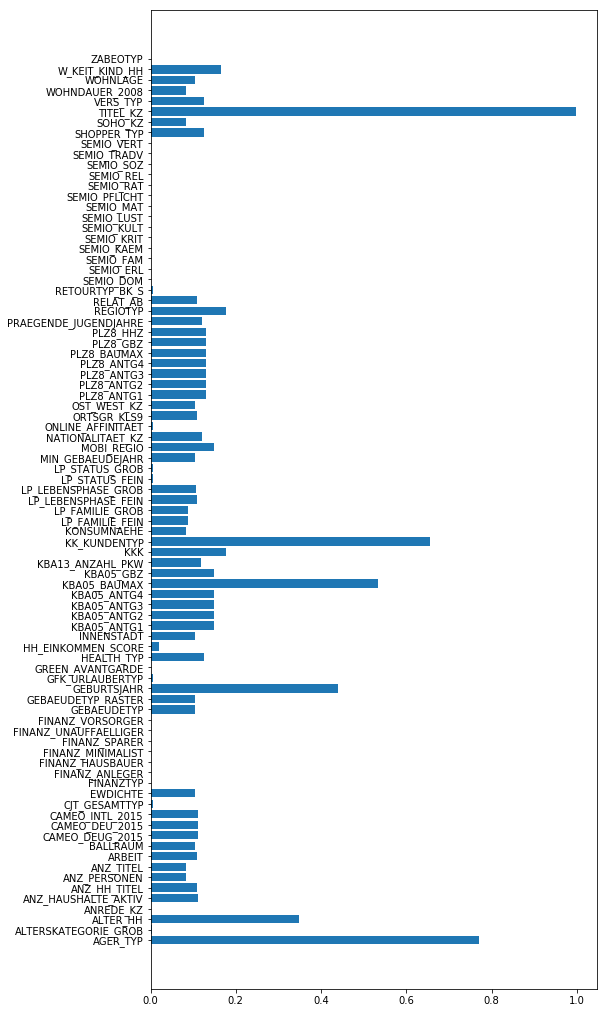

In [15]:
# Investigate patterns in the amount of missing data in each column

keys = nan_dict.keys()
values = nan_dict.values()

# Plot percent missing values for each column
plt.figure(figsize=(8,18))
plt.barh(list(keys),list(values));

# list(values)

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Choose columns that stand out as having many missing values and drop them from dataset
columns_missing_values = ['TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 'AGER_TYP']
azdias_clean.drop(columns_missing_values, axis=1, inplace=True)
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

#### Discussion 1.1.2: Assess Missing Data in Each Column

The columns that have a disproportionately higher percentage of missing values are the 6 that are above 30% missing values in the barplot above. These are the following: TITEL_KZ, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH, and AGER_TYP. These have been removed for the remainder of the analysis.
Otherwise, a few groups of several features seem to have the same number of missing values. For example, the PLZ8 macro-level features, regarding homes and buildings, has the same missing values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
# How much data is missing in each row of the dataset?

num_cols = azdias_clean.shape[1]

# Get percentage of missing values in each row
missing_values = azdias_clean.isnull().sum(axis=1)
missing_values = missing_values/num_cols

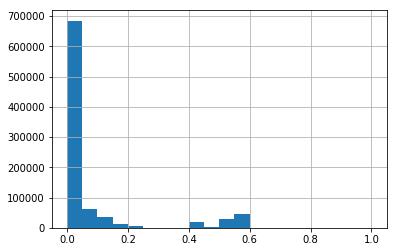

In [18]:
missing_values
missing_values[missing_values>0.4]

# Plot the distribution of number of missing values to find a break to distribute data into high missing values and low missing values
missing_values.hist(bins=np.linspace(0,1,21));

In [19]:
# Test if any are exactly at my chosen breaking point of 40%
missing_values[missing_values==0.4]

Series([], dtype: float64)

In [20]:
# Write code to divide the data into two subsets based on the number of missing values in each row

azdias_clean['missing_col_perc'] = missing_values

low_missing_values = azdias_clean[azdias_clean.missing_col_perc<=0.4] # None exactly at 0.4 so inequality doesn't matter
high_missing_values = azdias_clean[azdias_clean.missing_col_perc>0.4]

In [21]:
# Test
low_missing_values.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_col_perc
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.000000
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.000000
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.088608
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.000000
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0.000000


In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Function to repeat doing this for various features
def compare_countplots(col):
    plt.subplot(1,2,1)
    sns.countplot(x=col, data=low_missing_values)
    plt.subplot(1,2,2)
    sns.countplot(x=col, data=high_missing_values)
    plt.subplots_adjust(wspace=0.5)
    plt.show()

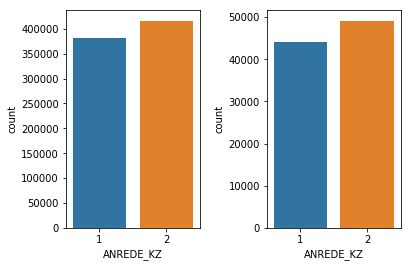

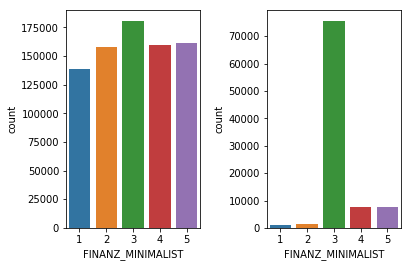

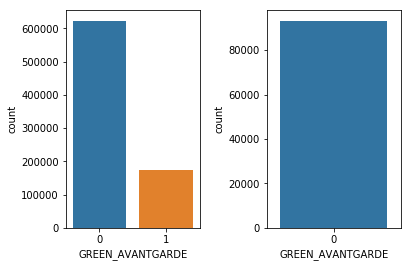

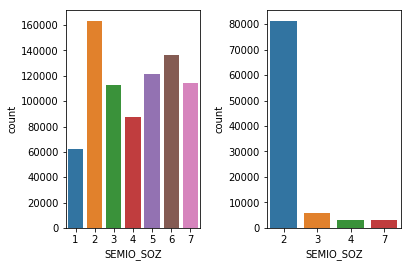

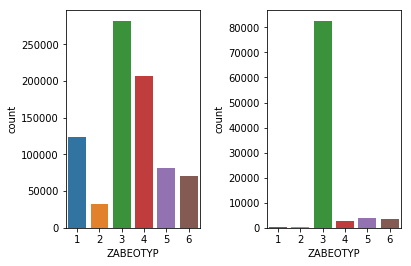

In [23]:
cols_to_plot = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'ZABEOTYP']

# plot columns with few missing values to compare high and low missing valued rows
for col in cols_to_plot:
    compare_countplots(col)

In [24]:
# Remove rows with many (>40% missing column values):

azdias_clean.drop(high_missing_values.index, axis=0, inplace=True)

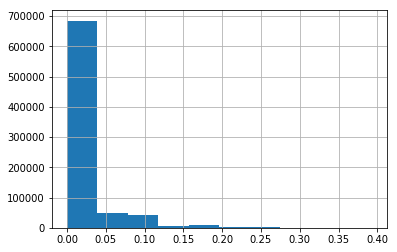

In [25]:
# Check

missing_values = azdias_clean.isnull().sum(axis=1)
missing_values = missing_values/num_cols
missing_values.hist();

#### Discussion 1.1.3: Assess Missing Data in Each Row

I divided the dataset between those points that had less than 40% missing values and those that had more. Looking at the values for the 5 columns above, only one seemed similar between the 2 groups. The others were qualitatively quite different. Nevertheless, I am continuing the analysis by dropping the rows with higher than 40% missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
# How many features are there of each data type?
pd.set_option('max_rows', None)
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
pd.reset_option('max_rows')

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical = feat_info[feat_info.type=='categorical']
dropped = ['TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 'AGER_TYP'] # were already dropped earlier
# list all categorical features that weren't already dropped in an earlier step
categorical.drop(categorical.loc[categorical['attribute'].isin(dropped)].index, axis=0, inplace=True)
categorical

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [29]:
cat_attributes = categorical.attribute.tolist()

# List value counts for each categorical variable to help decide what to do with it
for cat in cat_attributes:
    vals = azdias_clean[cat].value_counts()
    print(vals)

2    416184
1    381886
Name: ANREDE_KZ, dtype: int64
4.0    198296
3.0    147220
2.0    141269
5.0    111115
6.0    102108
1.0     93311
Name: CJT_GESAMTTYP, dtype: int64
6    289061
1    197175
5    106333
2    104774
4     55924
3     44803
Name: FINANZTYP, dtype: int64
12.0    130261
10.0    102831
8.0      83030
11.0     75103
5.0      70501
4.0      60422
9.0      57132
3.0      53101
1.0      50659
2.0      43859
7.0      40681
6.0      25739
Name: GFK_URLAUBERTYP, dtype: int64
0    622845
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
1.0     402556
10.0    128974
2.0      98555
11.0     48746
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    402556
5.0    188172
2.0     98555
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206853
9.0     136353
10.0    111574
2.0     111118
4.0      73973
3.0      68918
6.0      28896
5.0      27593
8.0      18837
7.0    

In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Re-encode OST_WEST_KZ numerically from a non-numerical binary categorical variable
west = azdias_clean[azdias_clean.OST_WEST_KZ=='W']
east = azdias_clean[azdias_clean.OST_WEST_KZ=='O']
azdias_clean.loc[west.index,'OST_WEST_KZ'] = 1
azdias_clean.loc[east.index,'OST_WEST_KZ'] = 0

In [31]:
azdias_clean.OST_WEST_KZ.value_counts()

1    629527
0    168543
Name: OST_WEST_KZ, dtype: int64

In [32]:
cat_attributes

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [33]:
# Drop multi-level categoricals from analysis for simplicity
cat_attributes.remove('OST_WEST_KZ') # Remove the one we already fixed

In [34]:
cat_attributes = [elem for elem in cat_attributes if elem not in ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP']] # Remove the ones that are binary and already numeric
cat_attributes

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [35]:
# Drop rest of multi-level categorical features
azdias_clean.drop(cat_attributes,axis=1,inplace=True)
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798070 entries, 1 to 891220
Data columns (total 67 columns):
ALTERSKATEGORIE_GROB     795267 non-null float64
ANREDE_KZ                798070 non-null int64
FINANZ_MINIMALIST        798070 non-null int64
FINANZ_SPARER            798070 non-null int64
FINANZ_VORSORGER         798070 non-null int64
FINANZ_ANLEGER           798070 non-null int64
FINANZ_UNAUFFAELLIGER    798070 non-null int64
FINANZ_HAUSBAUER         798070 non-null int64
GREEN_AVANTGARDE         798070 non-null int64
HEALTH_TYP               761341 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750721 non-null float64
PRAEGENDE_JUGENDJAHRE    769309 non-null float64
RETOURTYP_BK_S           793319 non-null float64
SEMIO_SOZ                798070 non-null int64
SEMIO_FAM                798070 non-null int64
SEMIO_REL                798070 non-null int64
SEMIO_MAT                798070 non-null int64
SEMIO_VERT               798070

#### Discussion 1.2.1: Re-Encode Categorical Features

First, I re-encoded OST_WEST_KZ as numbers (0 and 1) from a non-numerical binary categorical variable. For simplicity, I dropped the remaining categorical variables, which were all multi-level.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_clean.PRAEGENDE_JUGENDJAHRE.value_counts
forties = azdias_clean[(azdias_clean.PRAEGENDE_JUGENDJAHRE==1) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==2)]
fifties = azdias_clean[(azdias_clean.PRAEGENDE_JUGENDJAHRE==3) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==4)]
sixties = azdias_clean[(azdias_clean.PRAEGENDE_JUGENDJAHRE==5) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==6) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==7)]
seventies = azdias_clean[(azdias_clean.PRAEGENDE_JUGENDJAHRE==8) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==9)]
eighties = azdias_clean[(azdias_clean.PRAEGENDE_JUGENDJAHRE==10) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==11) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==12) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==13)]
nineties = azdias_clean[(azdias_clean.PRAEGENDE_JUGENDJAHRE==14) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==15)]

mainstream = azdias_clean[(azdias_clean.PRAEGENDE_JUGENDJAHRE==1) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==3) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==5) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==8) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==10) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==12) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==14)]
avantgarde = azdias_clean[(azdias_clean.PRAEGENDE_JUGENDJAHRE==2) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==4) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==6) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==7) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==9) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==11) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==13) | (azdias_clean.PRAEGENDE_JUGENDJAHRE==15)]

# Encode new decade variable
azdias_clean.loc[forties.index,'decade'] = 1
azdias_clean.loc[fifties.index,'decade'] = 2
azdias_clean.loc[sixties.index,'decade'] = 3
azdias_clean.loc[seventies.index,'decade'] = 4
azdias_clean.loc[eighties.index,'decade'] = 5
azdias_clean.loc[nineties.index,'decade'] = 6

# Encode new movement variable
azdias_clean.loc[mainstream.index,'movement'] = 1
azdias_clean.loc[avantgarde.index,'movement'] = 2

# Drop original variable
azdias_clean.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)

In [37]:
# Check
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798070 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB     795267 non-null float64
ANREDE_KZ                798070 non-null int64
FINANZ_MINIMALIST        798070 non-null int64
FINANZ_SPARER            798070 non-null int64
FINANZ_VORSORGER         798070 non-null int64
FINANZ_ANLEGER           798070 non-null int64
FINANZ_UNAUFFAELLIGER    798070 non-null int64
FINANZ_HAUSBAUER         798070 non-null int64
GREEN_AVANTGARDE         798070 non-null int64
HEALTH_TYP               761341 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750721 non-null float64
RETOURTYP_BK_S           793319 non-null float64
SEMIO_SOZ                798070 non-null int64
SEMIO_FAM                798070 non-null int64
SEMIO_REL                798070 non-null int64
SEMIO_MAT                798070 non-null int64
SEMIO_VERT               798070 non-null int64
SEMIO_LUST               798070 n

In [38]:
def tens_place(row):
    
    if type(row) is str or type(row) is int: # and np.isnan(row):
        return int(int(row)/10)
    else:
        try:
            if np.isnan(row):
                return row
        except:
            return row
        return int(int(row)/10)
def ones_place(row):
    
    if type(row) is str or type(row) is int:
        return int(int(row)%10)
    else:
        return row

# Investigate "CAMEO_INTL_2015" and engineer two new variables
# Wealth is associated with the 10s place of the variable, and life stage with the 1s place

azdias_clean['wealth'] = azdias_clean['CAMEO_INTL_2015'].apply(tens_place)
azdias_clean['life_stage'] = azdias_clean['CAMEO_INTL_2015'].apply(ones_place)

# Check
azdias_clean[['CAMEO_INTL_2015','wealth','life_stage']]

,CAMEO_INTL_2015,wealth,life_stage
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0
6,22,2.0,2.0
7,14,1.0,4.0
8,13,1.0,3.0
9,15,1.0,5.0
10,51,5.0,1.0


In [39]:
# Drop original variable

azdias_clean.drop('CAMEO_INTL_2015',axis=1,inplace=True)

In [40]:
# Drop rest of the mixed-type columns

mixed = feat_info[feat_info.type=='mixed']
mixed = mixed.attribute.tolist()
mixed.remove('PRAEGENDE_JUGENDJAHRE') # already dropped in dataframe
mixed.remove('CAMEO_INTL_2015') # already dropped in dataframe
mixed.remove('KBA05_BAUMAX') # also already dropped at earlier step
mixed

azdias_clean.drop(mixed,axis=1,inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I engineered new variables based on PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 according to the instructions. That is, I split the first variable in 2 new ones labeled decade (encoded with values 1-6) and movement (encoded as 1 or 2). The second I took the 10's digit as 'wealth' and 1's digit as 'life_stage'. The rest (4 after dropping one mixed type at an earlier step) I dropped from the analysis because 2 had inconsistent values and there was no way to divide it into the same number of new variables. WOHNLAGE was not ordinal and the values did not seem mutually exclusive. PLZ8_BAUMAX was not evenly-spaced ordinal either, and additionally appeared to contain the same information as other PLZ8 features that were kept.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [41]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

features_final = azdias_clean.columns.tolist()

feat_info_new = feat_info[feat_info.attribute.isin(features_final)]

# feat_info
feat_info_new

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
13,GREEN_AVANTGARDE,person,categorical,[]
14,HEALTH_TYP,person,ordinal,"[-1,0]"


In [42]:
num_ord_int_orig = feat_info[(feat_info.type=='numeric') | (feat_info.type=='ordinal') | (feat_info.type=='interval')]
num_ord_int_orig

num_ord_int_new = feat_info_new[(feat_info_new.type=='numeric') | (feat_info_new.type=='ordinal') | (feat_info_new.type=='interval')]

num_ord_int_orig.equals(num_ord_int_new) # Not equal, because we purposely removed some columns that had many missing values

False

In [43]:
# Copied from https://hackersandslackers.com/compare-rows-pandas-dataframes/
# input which can also be 'both' (present in both df), 'left_only', or 'right_only'

# Compare original to feature changes we made to make sure it is the way we intend
def dataframe_difference(df1, df2, which=None): # with which=None, we get rows that were in 1 but not the other
    """Find rows which are different between two DataFrames."""
    comparison_df = df1.merge(df2,
                              indicator=True,
                              how='outer')
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    return diff_df

In [44]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

df_new = dataframe_difference(num_ord_int_orig, num_ord_int_new)
df_new

,attribute,information_level,type,missing_or_unknown,_merge
7,GEBURTSJAHR,person,numeric,[0],left_only
24,ALTER_HH,household,interval,[0],left_only


In [45]:
columns_missing_values # these are the columns we dropped originally, so those wouldn't be in the compared new dataframe

['TITEL_KZ',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH',
 'AGER_TYP']

So, all numeric, ordinal, and interval-type features are kept (less the 2 that I removed because they were missing many values).

In [46]:
categorical_new = feat_info_new[feat_info_new.type=='categorical']
categorical_new
for att in categorical_new.attribute.tolist():
    print(azdias_clean[att].value_counts())

2    416184
1    381886
Name: ANREDE_KZ, dtype: int64
0    622845
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791353
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    394238
1.0    367103
Name: VERS_TYP, dtype: int64
1    629527
0    168543
Name: OST_WEST_KZ, dtype: int64


All categorical are binary and numerically encoded.

In [47]:
mixed_new = feat_info_new[feat_info_new.type=='mixed'] # this should be empty
mixed_new

,attribute,information_level,type,missing_or_unknown


There are in fact no mixed-type columns left. Now verify additional columns are only those I engineered.

In [48]:
features_original = feat_info.attribute.tolist()
# features_original
(list(set(features_final) - set(features_original)))

['movement', 'wealth', 'missing_col_perc', 'life_stage', 'decade']

The only additional columns are the ones I engineered from the original, besides that I forgot to drop one column I added for earlier analysis.

In [49]:
azdias_clean.drop('missing_col_perc',axis=1,inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [50]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df_clean = df.copy()
    
    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')
    
    feat_info_to_dict = feat_info.drop(['information_level','type'],axis=1)
    feat_info_dict = feat_info_to_dict.set_index('attribute')['missing_or_unknown'].to_dict()
    
    
    for key in feat_info_dict:
        feat_info_dict[key] = feat_info_dict[key].strip('][').split(',')
        feat_info_dict[key] = [int(missing) if (missing!='X' and missing!='XX' and missing!='') # convert ints that are listed as strings to int
                                         else missing for missing in feat_info_dict[key]]

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for key in feat_info_dict:
        df_clean[key].replace(to_replace=feat_info_dict[key],value=np.nan,inplace=True)
    
    # remove selected columns and rows, ...
    # columns:
    columns_missing_values = ['TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 'AGER_TYP']
    df_clean.drop(columns_missing_values, axis=1, inplace=True)
    
    # rows:
    num_cols = df_clean.shape[1]
    missing_values = df_clean.isnull().sum(axis=1)
    missing_values = missing_values/num_cols
    
    df_clean['missing_col_perc'] = missing_values
    high_missing_values = df_clean[df_clean.missing_col_perc>0.4]
    
    # Remove rows with many (>40% missing column values):
    df_clean.drop(high_missing_values.index, axis=0, inplace=True)
    
    # select, re-encode, and engineer column values.
    # Re-encode OST_WEST_KZ numerically from a non-numerical binary categorical variable
    west = df_clean[df_clean.OST_WEST_KZ=='W']
    east = df_clean[df_clean.OST_WEST_KZ=='O']
    df_clean.loc[west.index,'OST_WEST_KZ'] = 1
    df_clean.loc[east.index,'OST_WEST_KZ'] = 0
    
    categorical = feat_info[feat_info.type=='categorical']
    dropped = ['TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH', 'AGER_TYP'] # were already dropped earlier
    categorical.drop(categorical.loc[categorical['attribute'].isin(dropped)].index, axis=0, inplace=True)
    cat_attributes = categorical.attribute.tolist()
    cat_attributes.remove('OST_WEST_KZ') # Remove the one we already fixed
    # Remove the ones that are binary and already numeric
    cat_attributes = [elem for elem in cat_attributes if elem not in ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP']] 
    df_clean.drop(cat_attributes,axis=1,inplace=True)
    
    # Engineer mixed-type features
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df_clean.PRAEGENDE_JUGENDJAHRE.value_counts
    forties = df_clean[(df_clean.PRAEGENDE_JUGENDJAHRE==1) | (df_clean.PRAEGENDE_JUGENDJAHRE==2)]
    fifties = df_clean[(df_clean.PRAEGENDE_JUGENDJAHRE==3) | (df_clean.PRAEGENDE_JUGENDJAHRE==4)]
    sixties = df_clean[(df_clean.PRAEGENDE_JUGENDJAHRE==5) | (df_clean.PRAEGENDE_JUGENDJAHRE==6) | (df_clean.PRAEGENDE_JUGENDJAHRE==7)]
    seventies = df_clean[(df_clean.PRAEGENDE_JUGENDJAHRE==8) | (df_clean.PRAEGENDE_JUGENDJAHRE==9)]
    eighties = df_clean[(df_clean.PRAEGENDE_JUGENDJAHRE==10) | (df_clean.PRAEGENDE_JUGENDJAHRE==11) | (df_clean.PRAEGENDE_JUGENDJAHRE==12) | (df_clean.PRAEGENDE_JUGENDJAHRE==13)]
    nineties = df_clean[(df_clean.PRAEGENDE_JUGENDJAHRE==14) | (df_clean.PRAEGENDE_JUGENDJAHRE==15)]

    mainstream = df_clean[(df_clean.PRAEGENDE_JUGENDJAHRE==1) | (df_clean.PRAEGENDE_JUGENDJAHRE==3) | (df_clean.PRAEGENDE_JUGENDJAHRE==5) | (df_clean.PRAEGENDE_JUGENDJAHRE==8) | (df_clean.PRAEGENDE_JUGENDJAHRE==10) | (df_clean.PRAEGENDE_JUGENDJAHRE==12) | (df_clean.PRAEGENDE_JUGENDJAHRE==14)]
    avantgarde = df_clean[(df_clean.PRAEGENDE_JUGENDJAHRE==2) | (df_clean.PRAEGENDE_JUGENDJAHRE==4) | (df_clean.PRAEGENDE_JUGENDJAHRE==6) | (df_clean.PRAEGENDE_JUGENDJAHRE==7) | (df_clean.PRAEGENDE_JUGENDJAHRE==9) | (df_clean.PRAEGENDE_JUGENDJAHRE==11) | (df_clean.PRAEGENDE_JUGENDJAHRE==13) | (df_clean.PRAEGENDE_JUGENDJAHRE==15)]

    df_clean.loc[forties.index,'decade'] = 1
    df_clean.loc[fifties.index,'decade'] = 2
    df_clean.loc[sixties.index,'decade'] = 3
    df_clean.loc[seventies.index,'decade'] = 4
    df_clean.loc[eighties.index,'decade'] = 5
    df_clean.loc[nineties.index,'decade'] = 6

    df_clean.loc[mainstream.index,'movement'] = 1
    df_clean.loc[avantgarde.index,'movement'] = 2

    df_clean.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df_clean['wealth'] = df_clean['CAMEO_INTL_2015'].apply(tens_place)
    df_clean['life_stage'] = df_clean['CAMEO_INTL_2015'].apply(ones_place)
    df_clean.drop('CAMEO_INTL_2015',axis=1,inplace=True)
    
    # Drop rest of the mixed-type columns
    mixed = feat_info[feat_info.type=='mixed']
    mixed = mixed.attribute.tolist()
    mixed.remove('PRAEGENDE_JUGENDJAHRE') # already dropped in dataframe
    mixed.remove('CAMEO_INTL_2015') # already dropped in dataframe
    mixed.remove('KBA05_BAUMAX') # also already dropped at earlier step
    df_clean.drop(mixed,axis=1,inplace=True)
    
    df_clean.drop('missing_col_perc',axis=1,inplace=True)
    
    # Return the cleaned dataframe.
    return df_clean, high_missing_values
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [51]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798070 entries, 1 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     795267 non-null float64
ANREDE_KZ                798070 non-null int64
FINANZ_MINIMALIST        798070 non-null int64
FINANZ_SPARER            798070 non-null int64
FINANZ_VORSORGER         798070 non-null int64
FINANZ_ANLEGER           798070 non-null int64
FINANZ_UNAUFFAELLIGER    798070 non-null int64
FINANZ_HAUSBAUER         798070 non-null int64
GREEN_AVANTGARDE         798070 non-null int64
HEALTH_TYP               761341 non-null float64
RETOURTYP_BK_S           793319 non-null float64
SEMIO_SOZ                798070 non-null int64
SEMIO_FAM                798070 non-null int64
SEMIO_REL                798070 non-null int64
SEMIO_MAT                798070 non-null int64
SEMIO_VERT               798070 non-null int64
SEMIO_LUST               798070 non-null int64
SEMIO_ERL                798070 non-null int64
SEMIO_KULT               798070 non-n

In [52]:
from sklearn.preprocessing import Imputer

fill_missing = Imputer(strategy='most_frequent')
azdias_clean_imputed = pd.DataFrame(fill_missing.fit_transform(azdias_clean))
# azdias_clean_imputed
azdias_clean_imputed.columns = azdias_clean.columns
azdias_clean_imputed.index = azdias_clean.index
azdias_clean_imputed.shape

(798070, 64)

In [53]:
# Test
azdias_clean_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [54]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_clean_imputed_scaled = pd.DataFrame(scaler.fit_transform(azdias_clean_imputed))
azdias_clean_imputed_scaled.columns = azdias_clean.columns
azdias_clean_imputed_scaled.index = azdias_clean.index
azdias_clean_imputed_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
1,-1.766651,0.957909,-1.494590,1.537915,-1.040683,1.465956,0.958624,1.339321,-0.530406,1.010153,...,0.442539,1.455859,0.574312,-0.171399,-0.127039,0.684884,1.098060,-0.530406,1.175655,-1.248888
2,0.200522,0.957909,-1.494590,0.864556,-1.766970,-0.571003,0.244102,1.339321,1.885350,1.010153,...,-0.934788,0.419749,0.574312,-0.171399,-0.127039,-0.789027,1.098060,1.885350,-0.869680,0.767096
3,1.184109,0.957909,0.683149,-0.482163,1.138176,-0.571003,-1.184941,-0.791198,-0.530406,-0.311827,...,-0.934788,-0.616361,0.574312,-1.173148,-0.997548,-0.052072,-0.267788,-0.530406,-1.551458,-0.576893
4,0.200522,-1.043941,0.683149,0.191196,0.411889,-1.249989,0.244102,-0.791198,-0.530406,1.010153,...,0.442539,-0.616361,-0.337193,0.830349,0.308215,1.421840,-0.267788,-0.530406,0.493877,0.095102
5,-1.766651,0.957909,-0.042764,-1.155523,1.138176,-0.571003,-0.470419,1.339321,-0.530406,1.010153,...,0.442539,1.455859,1.485816,-1.173148,-0.997548,-0.052072,-1.633635,-0.530406,1.175655,0.767096


In [55]:
azdias_clean_imputed_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798070 entries, 1 to 891220
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     798070 non-null float64
ANREDE_KZ                798070 non-null float64
FINANZ_MINIMALIST        798070 non-null float64
FINANZ_SPARER            798070 non-null float64
FINANZ_VORSORGER         798070 non-null float64
FINANZ_ANLEGER           798070 non-null float64
FINANZ_UNAUFFAELLIGER    798070 non-null float64
FINANZ_HAUSBAUER         798070 non-null float64
GREEN_AVANTGARDE         798070 non-null float64
HEALTH_TYP               798070 non-null float64
RETOURTYP_BK_S           798070 non-null float64
SEMIO_SOZ                798070 non-null float64
SEMIO_FAM                798070 non-null float64
SEMIO_REL                798070 non-null float64
SEMIO_MAT                798070 non-null float64
SEMIO_VERT               798070 non-null float64
SEMIO_LUST               798070 non-null float64
SEMIO_ERL                798070 non-null float64
SEMIO_K

### Discussion 2.1: Apply Feature Scaling

I chose to use an imputer to fill in the remaining missing values. There were a significant amount of missing values, and after removing several columns and many rows due to missing values, I didn't want to remove any more data. The more complicated procedure described in the directions sounds like it might be more accurate/consistent, but I simplified it to just imputing the values before scaling using the most frequent value in each column. I thought this was more reasonable than something like an average, which wouldn't make sense for many of the variables that are categorical or ordinal.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [56]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

def do_pca(data,n_components=None): # copied from Lesson 4 helper functions with modification to not include n_components input
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
#     X = StandardScaler().fit_transform(data) # we do this earlier in this project
    if n_components is None:
        pca = PCA()
    else:
        pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

pca, X_pca = do_pca(azdias_clean_imputed_scaled)

In [57]:
# Investigate the variance accounted for by each principal component.

def pca_results(full_dataset, pca, graph=True): # Also copied from helper function in lessons
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    if graph:
        # Create a bar plot visualization
        fig, ax = plt.subplots(figsize = (14,8))

        # Plot the feature weights as a function of the components
        components.plot(ax = ax, kind = 'bar');
        ax.set_ylabel("Feature Weights")
        ax.set_xticklabels(dimensions, rotation=0)


        # Display the explained variance ratios
        for i, ev in enumerate(pca.explained_variance_ratio_):
            ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

table = pca_results(azdias_clean_imputed_scaled, pca, False)
table

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
Dimension 1,0.1655,-0.1256,0.0075,-0.2231,0.1531,-0.1202,0.0751,0.0811,0.1595,-0.1102,...,0.2169,0.0422,-0.1664,0.1426,0.1968,0.1349,0.1123,-0.1102,0.2046,-0.1252
Dimension 2,0.1331,0.2563,0.0931,0.0594,-0.2317,0.2292,-0.2027,-0.2255,0.1218,-0.0184,...,0.0963,0.0159,-0.0752,0.0718,0.0966,0.0693,-0.2386,-0.0184,0.0792,-0.0012
Dimension 3,0.0947,0.0796,-0.3674,0.1545,-0.1072,0.1017,-0.1910,-0.1011,-0.0397,0.0471,...,0.0492,0.0056,-0.0405,0.0374,0.0503,0.0344,-0.1117,0.0471,0.0302,-0.0100
Dimension 4,0.0529,-0.0480,0.0375,0.0623,-0.0015,-0.0185,-0.1221,0.0784,-0.1009,0.4008,...,0.0797,0.1346,0.0349,0.0549,0.2484,0.0979,0.0301,0.4008,-0.1228,0.0617
Dimension 5,0.0370,-0.0002,0.0082,0.0874,-0.0085,-0.0609,0.0404,-0.0531,-0.0860,0.0560,...,0.0208,-0.4847,-0.4025,0.2256,0.0914,0.1529,0.0172,0.0560,-0.0044,0.0233
Dimension 6,0.0318,0.0172,0.0112,-0.0003,0.0023,-0.0367,0.0129,0.0008,-0.0357,0.0210,...,0.0815,-0.0190,-0.0784,-0.1736,-0.0597,-0.2045,0.0344,0.0210,-0.0733,0.0436
Dimension 7,0.0284,0.0607,-0.0511,0.0806,0.0354,-0.0107,0.0492,0.0656,-0.2320,-0.0164,...,0.0349,0.2231,0.1323,0.0267,0.1063,0.0468,0.0862,-0.0164,0.0251,-0.0952
Dimension 8,0.0258,-0.0943,-0.0358,-0.0149,0.0245,0.0530,0.0067,-0.0122,0.0332,-0.0318,...,-0.0270,-0.0060,0.0425,-0.0214,0.0937,0.0123,0.0003,-0.0318,-0.0449,0.0251
Dimension 9,0.0238,0.1035,-0.0744,-0.1473,0.1908,-0.1545,0.1760,0.1133,0.0803,0.0405,...,0.0467,-0.0260,-0.0477,-0.0581,-0.1004,-0.0397,0.1842,0.0405,0.0521,-0.0316
Dimension 10,0.0226,-0.0335,0.0576,-0.0384,-0.0544,0.0467,0.0560,-0.1946,0.2150,-0.0242,...,0.0840,0.2261,0.1318,0.1962,0.0089,0.0884,-0.0898,-0.0242,0.0576,0.0806


0.9053

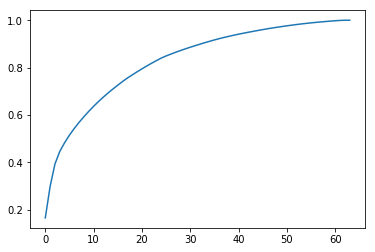

In [58]:
variance_cumsum = table['Explained Variance'].cumsum()
var_list = variance_cumsum.tolist()
plt.plot(var_list);
# var_list[21] # variance explained by first 22 components
# var_list[26]
var_list[33]

In [59]:
# Re-apply PCA to the data while selecting for number of components to retain.

def scree_plot(pca): # Copied from helper functions in lessons
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


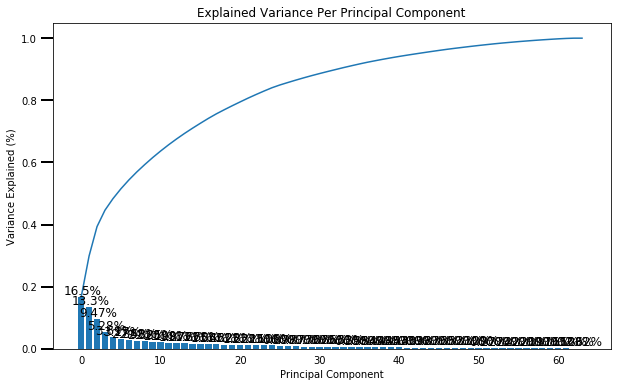

In [60]:
scree_plot(pca)
# pca, X_pca = do_pca(azdias_clean_imputed_scaled, 22)
# pca, X_pca = do_pca(azdias_clean_imputed_scaled, 27)
pca, X_pca = do_pca(azdias_clean_imputed_scaled, 34)

### Discussion 2.2: Perform Dimensionality Reduction

There was no clear knee in the curve which explained most of the variance, so I chose the number that made 90% of variance explained, which was 34 principal components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [61]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Function for finding weights for principal components
def list_weights(df, pca, component):
    table = pca_results(df, pca, False)
    row = table.iloc[component-1,1:].sort_values(ascending=False)
    weights_descending = row.tolist()
    features_descending = row.index.tolist()
    return weights_descending, features_descending

# weights and features for 1st component
weights, features = list_weights(azdias_clean_imputed_scaled, pca, 1)
print(weights)
print('\n')
print(features)

[0.2253, 0.2169, 0.2046, 0.2022, 0.1968, 0.1947, 0.1595, 0.154, 0.1537, 0.1531, 0.1426, 0.1367, 0.1361, 0.1349, 0.1212, 0.1186, 0.1123, 0.0996, 0.0937, 0.0824, 0.0811, 0.081, 0.0755, 0.0751, 0.0603, 0.0433, 0.0422, 0.0412, 0.0396, 0.0394, 0.0364, 0.0339, 0.0326, 0.0238, 0.0137, 0.0075, 0.0038, -0.002, -0.0042, -0.0217, -0.0406, -0.0413, -0.0429, -0.0537, -0.0612, -0.0739, -0.0769, -0.0781, -0.0802, -0.1102, -0.1102, -0.1172, -0.1202, -0.1252, -0.1256, -0.1273, -0.1646, -0.1664, -0.1674, -0.2144, -0.2161, -0.2231, -0.2248, -0.2257]


['PLZ8_ANTG3', 'PLZ8_ANTG4', 'wealth', 'HH_EINKOMMEN_SCORE', 'ORTSGR_KLS9', 'EWDICHTE', 'FINANZ_HAUSBAUER', 'KBA05_ANTG4', 'PLZ8_ANTG2', 'FINANZ_SPARER', 'ARBEIT', 'KBA05_ANTG3', 'ANZ_HAUSHALTE_AKTIV', 'RELAT_AB', 'SEMIO_PFLICHT', 'SEMIO_REL', 'decade', 'SEMIO_RAT', 'SEMIO_TRADV', 'SEMIO_MAT', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_FAM', 'SEMIO_KULT', 'FINANZ_ANLEGER', 'REGIOTYP', 'SEMIO_SOZ', 'PLZ8_HHZ', 'HEALTH_TYP', 'KKK', 'SEMIO_KAEM', 'W_KEIT_KIND_HH', 'ANZ_H

In [62]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights, features = list_weights(azdias_clean_imputed_scaled, pca, 2)
print(weights)
print('\n')
print(features)

[0.2563, 0.2299, 0.2292, 0.1801, 0.1619, 0.1218, 0.1178, 0.1164, 0.1147, 0.0984, 0.0979, 0.0966, 0.0963, 0.0931, 0.0792, 0.0752, 0.0745, 0.0718, 0.0693, 0.0682, 0.0665, 0.062, 0.0594, 0.0585, 0.0506, 0.0321, 0.0321, 0.0159, 0.0119, 0.0068, 0.0006, -0.0012, -0.0013, -0.002, -0.0184, -0.0184, -0.0275, -0.038, -0.0473, -0.049, -0.057, -0.0642, -0.0647, -0.0728, -0.0744, -0.0748, -0.0752, -0.0797, -0.0808, -0.0924, -0.0963, -0.1032, -0.1617, -0.1654, -0.167, -0.1843, -0.2027, -0.2197, -0.2254, -0.2255, -0.2283, -0.2317, -0.2386, -0.2536]


['ALTERSKATEGORIE_GROB', 'SEMIO_ERL', 'FINANZ_VORSORGER', 'SEMIO_LUST', 'RETOURTYP_BK_S', 'FINANZ_HAUSBAUER', 'SEMIO_KRIT', 'SEMIO_KAEM', 'W_KEIT_KIND_HH', 'PLZ8_ANTG3', 'EWDICHTE', 'ORTSGR_KLS9', 'PLZ8_ANTG4', 'ANREDE_KZ', 'wealth', 'KBA05_ANTG4', 'SEMIO_DOM', 'ARBEIT', 'RELAT_AB', 'PLZ8_ANTG2', 'ANZ_HAUSHALTE_AKTIV', 'HH_EINKOMMEN_SCORE', 'FINANZ_MINIMALIST', 'WOHNDAUER_2008', 'KBA05_ANTG3', 'VERS_TYP', 'ANZ_HH_TITEL', 'PLZ8_HHZ', 'REGIOTYP', 'ANZ_TITE

In [63]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights, features = list_weights(azdias_clean_imputed_scaled, pca, 3)
print(weights)
print('\n')
print(features)

[0.3447, 0.2619, 0.2488, 0.2339, 0.1545, 0.109, 0.1017, 0.0851, 0.0796, 0.0677, 0.0644, 0.0557, 0.0503, 0.0495, 0.0492, 0.0484, 0.0471, 0.0471, 0.0374, 0.0344, 0.0327, 0.0327, 0.0302, 0.03, 0.0268, 0.0139, 0.0119, 0.0096, 0.0056, 0.0016, 0.0002, -0.0067, -0.0074, -0.01, -0.0107, -0.0155, -0.0163, -0.0164, -0.0184, -0.0221, -0.0239, -0.0268, -0.029, -0.0321, -0.0341, -0.0372, -0.0397, -0.0405, -0.0405, -0.0457, -0.0494, -0.0557, -0.0793, -0.0801, -0.1011, -0.1072, -0.1117, -0.1753, -0.191, -0.2177, -0.2752, -0.3131, -0.335, -0.3674]


['SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_KULT', 'FINANZ_MINIMALIST', 'RETOURTYP_BK_S', 'FINANZ_VORSORGER', 'W_KEIT_KIND_HH', 'ALTERSKATEGORIE_GROB', 'SEMIO_REL', 'SEMIO_LUST', 'SEMIO_MAT', 'ORTSGR_KLS9', 'EWDICHTE', 'PLZ8_ANTG4', 'PLZ8_ANTG3', 'GREEN_AVANTGARDE', 'movement', 'ARBEIT', 'RELAT_AB', 'WOHNDAUER_2008', 'PLZ8_ANTG2', 'wealth', 'KBA05_ANTG4', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KBA05_ANTG3', 'ANZ_TITEL', 'PLZ8_HHZ', 'VERS_TYP', 'SOHO_K

### Discussion 2.3: Interpret Principal Components

The first principal component is most positively correlated with PLZ8_ANTG3, which is number of 6-8 family homes in the region. The next highest-weighted feature is PLZ8_ANTG4, which is number of 10+ family houses in the region. Next highest is "wealth" which is an engineered variable from CAMEO_INTL_2015 and relates to the wealth of the household. This component is most negatively correlated with the variable represeting 1-2 family houses in the region and movement patterns of the region. So, the first component corresponds to regional characteristics where there are larger, poorer families.

The second principal component is mostly correlated with estimated age, having a lower affinity of being event-oriented, and low-affinity towards being financially "prepared". The features with strongest negative weights are low affinity for being religious, "dominating movement of person's youth" (note "decade" variable comes from PRAEGENDE_JUGENDJAHRE variable), and low affinity for being a money-saver. So, the 2nd component corresponds to personal-level features of being being religious but not event-oriented, generally older and not from the 90's youth, and more financially a money-saver than simply being "prepared".

The third principal component is mostly correlated with lower affinity for a "dreamful", socially-minded, family-minded, and cultural-minded personality typologies. It is negatively correlated with gender, lower affinity for a "combative attitude" and "dominant-minded" personality typology. So, this component corresponds to personal-level features of being male and having more combative and dominant-minded personalities over being family, social, and culturally-orieinted.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [64]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [65]:
# Investigate the change in within-cluster distance across number of clusters.

def k_means_clusters_score(df, number_of_cluster):

    kmeans = KMeans(n_clusters = number_of_cluster)

    model = kmeans.fit(df)

    score = np.abs(model.score(df))

    return score


scores = []

# kvalues = list(range(1,20))
# kvalues = [1,2,4,6,8,10,12,14,15,16,18,20,21,22]
# kvalues = [1,2,4,6,8,10,12,14,15,16,18,20,21,22,25,30]
kvalues = [2,4,6,8,10,12,14,15,16,18,20,21,22,25]

for k in kvalues:
    scores.append(k_means_clusters_score(X_pca, k))

plt.plot(kvalues, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Average Distance from Centroid');

In [66]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 10)
model = kmeans.fit(X_pca)
labels = model.predict(X_pca)

(array([ 95878.,  58251.,  84768.,  87962.,  92551.,  63120.,  60262.,
         99245.,  87745.,  68288.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

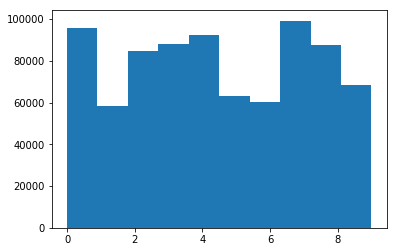

In [67]:
# Rough look at distribution
labels
plt.hist(labels)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I made a plot of number of clusters vs. average distance to centroid for a variety of clusters (from 2 to 25), and looked for a knee in the curve. I decided on keeping 10 clusters for the further analysis because beyond that there was only a small relative reduction in distance, i.e. that was the approximate knee in the curve.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter =  ';')

In [69]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean, high_missing_values_customers = clean_data(customers)

# customers_clean_imputed= pd.DataFrame(fill_missing.fit_transform(customers_clean))
# customers_clean_imputed_scaled= pd.DataFrame(scaler.fit_transform(customers_clean_imputed))
customers_clean_imputed= pd.DataFrame(fill_missing.transform(customers_clean))
customers_clean_imputed_scaled= pd.DataFrame(scaler.transform(customers_clean_imputed))
customers_clean_imputed_scaled.columns = azdias_clean_imputed_scaled.columns
customers_pca = pca.transform(customers_clean_imputed_scaled)
customers_labels = model.predict(customers_pca)
customers_labels


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


array([6, 1, 4, ..., 6, 3, 4], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

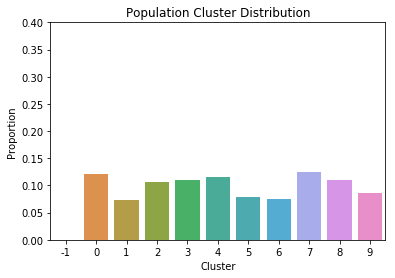

In [70]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


# Plot principal components for general population

population_cluster_counts=pd.DataFrame(labels)
population_cluster_counts.columns=['cluster']
pop_counts = population_cluster_counts.cluster.value_counts()
pop_counts.loc['-1'] = high_missing_values.shape[1]

ord = [-1,0,1,2,3,4,5,6,7,8,9]
ax = sns.barplot(x=pop_counts.index,y=pop_counts.values/pop_counts.values.sum(),order=ord);
ax.set(xlabel='Cluster', ylabel='Proportion', title='Population Cluster Distribution', ylim=(0,0.4))
plt.show()

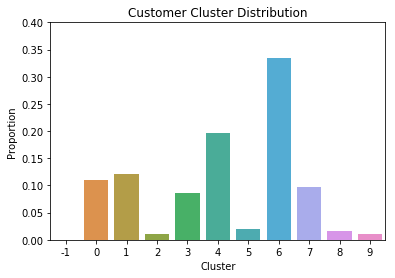

In [71]:
# Plot principal components for customers

customer_cluster_counts=pd.DataFrame(customers_labels)
customer_cluster_counts.columns=['cluster']
cust_counts = customer_cluster_counts.cluster.value_counts()
cust_counts.loc['-1'] = high_missing_values_customers.shape[1]

ord = [-1,0,1,2,3,4,5,6,7,8,9]
ax = sns.barplot(x=cust_counts.index,y=cust_counts.values/cust_counts.values.sum(),order=ord);
ax.set(xlabel='Cluster', ylabel='Proportion', title='Customer Cluster Distribution', ylim=(0,0.4))
plt.show()

In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

weights, features = list_weights(customers_clean_imputed_scaled, pca, 6)
print(weights)
print('\n')
print(features)

[0.4215, 0.3653, 0.2462, 0.1724, 0.0815, 0.0795, 0.065, 0.0634, 0.0436, 0.0344, 0.0308, 0.0262, 0.0248, 0.021, 0.021, 0.0172, 0.0159, 0.015, 0.0129, 0.0112, 0.0094, 0.0089, 0.0063, 0.0023, 0.0021, 0.0016, 0.0008, -0.0003, -0.0007, -0.0037, -0.0044, -0.0088, -0.0111, -0.0164, -0.0184, -0.019, -0.0208, -0.024, -0.0338, -0.0357, -0.0367, -0.0482, -0.0515, -0.0522, -0.0597, -0.0679, -0.0733, -0.076, -0.077, -0.0784, -0.085, -0.0854, -0.0994, -0.1053, -0.1187, -0.1374, -0.1667, -0.1708, -0.1736, -0.184, -0.2045, -0.2093, -0.2546, -0.4301]


['KBA05_ANTG4', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'MIN_GEBAEUDEJAHR', 'PLZ8_ANTG4', 'ONLINE_AFFINITAET', 'ANZ_TITEL', 'ANZ_PERSONEN', 'life_stage', 'decade', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'SEMIO_VERT', 'movement', 'GREEN_AVANTGARDE', 'ALTERSKATEGORIE_GROB', 'INNENSTADT', 'KONSUMNAEHE', 'FINANZ_ANLEGER', 'ANREDE_KZ', 'SEMIO_TRADV', 'SEMIO_ERL', 'SEMIO_MAT', 'FINANZ_SPARER', 'SEMIO_SOZ', 'SOHO_KZ', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_MINIMALIST', 'SE

In [73]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

weights, features = list_weights(customers_clean_imputed_scaled, pca, 2)
print(weights)
print('\n')
print(features)

[0.2563, 0.2299, 0.2292, 0.1801, 0.1619, 0.1218, 0.1178, 0.1164, 0.1147, 0.0984, 0.0979, 0.0966, 0.0963, 0.0931, 0.0792, 0.0752, 0.0745, 0.0718, 0.0693, 0.0682, 0.0665, 0.062, 0.0594, 0.0585, 0.0506, 0.0321, 0.0321, 0.0159, 0.0119, 0.0068, 0.0006, -0.0012, -0.0013, -0.002, -0.0184, -0.0184, -0.0275, -0.038, -0.0473, -0.049, -0.057, -0.0642, -0.0647, -0.0728, -0.0744, -0.0748, -0.0752, -0.0797, -0.0808, -0.0924, -0.0963, -0.1032, -0.1617, -0.1654, -0.167, -0.1843, -0.2027, -0.2197, -0.2254, -0.2255, -0.2283, -0.2317, -0.2386, -0.2536]


['ALTERSKATEGORIE_GROB', 'SEMIO_ERL', 'FINANZ_VORSORGER', 'SEMIO_LUST', 'RETOURTYP_BK_S', 'FINANZ_HAUSBAUER', 'SEMIO_KRIT', 'SEMIO_KAEM', 'W_KEIT_KIND_HH', 'PLZ8_ANTG3', 'EWDICHTE', 'ORTSGR_KLS9', 'PLZ8_ANTG4', 'ANREDE_KZ', 'wealth', 'KBA05_ANTG4', 'SEMIO_DOM', 'ARBEIT', 'RELAT_AB', 'PLZ8_ANTG2', 'ANZ_HAUSHALTE_AKTIV', 'HH_EINKOMMEN_SCORE', 'FINANZ_MINIMALIST', 'WOHNDAUER_2008', 'KBA05_ANTG3', 'VERS_TYP', 'ANZ_HH_TITEL', 'PLZ8_HHZ', 'REGIOTYP', 'ANZ_TITE

In [74]:
# Alternate method

# centroid6=scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[6]))
# centroid6
# pd.set_option('max_rows', None)
# col_weights_clust6 = pd.Series(data=centroid6, index=customers_clean_imputed_scaled.columns)
# col_weights_clust6

In [75]:
# centroid2=scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[2]))
# centroid2
# col_weights_clust2 = pd.Series(data=centroid2, index=customers_clean_imputed_scaled.columns)
# col_weights_clust2

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The proportions of datapoints within each cluster vary quite a lot between the general population and company customers. Cluster 6 for example appears to be overrepresented by the customer data with about 35% of the data in that cluster compared to only about 8% in the general population. On the other hand, Cluster 2 appears to be underrepresented by the customer data with about 1% of the data falling in that cluster vs. about 10% in the general population.

The features with strongest weights for Cluster 6 are some of the micro/macrocell and building level features. The strongest positive weight is on the "number of 10+ family homes in microcell" feature, while the strongest negative is for "number of 3-5 family homes in microcell". Similarly, the 2nd strongest negative weight was for "4-5 family homes in the PLZ region". This suggests that customers of the company tend to live in areas with bigger families. The second highest positive weight was for "number of households in building", which suggests customers living in apartments, or in multi-family units with families living close to one-another. To a lesser extent, the next highest positive weight was for "number of professional academic title holders in building", which doesn't itself say anything about the customer's education, but again suggests more populous buildings.

The weights for Cluster 2 are more evenly distributed. The features with strongest weights for this cluster are, in the person-level features this time. They are: "estimated age based on given name analysis", "personality typology" for being "event-oriented", and "financial typology" of "being prepared". The features with strongest negative weights are: "personality typology" for being religious, "dominating movement of person's youth" (note "decade" variable comes from PRAEGENDE_JUGENDJAHRE variable), and "financial typology" of "money-saver". This suggests that customers tend to be event-oriented but not be as religious, generally not older and from the 90's youth, and are more financially simply "prepared" over being "money-savers".

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.